# Visit Count Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

   The aim of this prediction is to be able to predict the average number of visit counts of a patient based on their insurance. The hypothesis is that insurances with a larger contractual adjustment result in higher out of pocket costs for patients, resulting in a lower average visit count normalized by age. Thus, the predictive power could be applied standalone or in a future composite model, who's purpose would be to predict overall profitability based on insurance, although future iterations would likely include other demographic predictors to give a more complete picture.

In [8]:
df_raw = pd.read_excel("Overall_Raw_Adj.xls").drop('Charge Balance', axis=1)

In [9]:
df_raw

,Insurance,Patient_Id,Date,Procedure,Units,Charge_Resp,Charge,Contractual_Adj
0,Absolute Total Care Medicaid,72181,1/2/2020,90460,1,P,22.0,-1.84
1,Absolute Total Care Medicaid,72181,1/2/2020,90461,2,P,40.0,-16.24
2,Absolute Total Care Medicaid,72181,1/2/2020,99391,1,P,125.0,-28.41
3,Absolute Total Care Medicaid,72508,1/8/2020,99381,1,P,151.0,-43.87
4,Absolute Total Care Medicaid,72307,1/10/2020,90460,1,P,22.0,-1.84
...,...,...,...,...,...,...,...,...
36516,Valenz Tucker McClancy,69779,10/18/2021,90471,1,P,25.0,0.00
36517,Valenz Tucker McClancy,69779,10/18/2021,90686,1,P,30.0,0.00
36518,Valenz Tucker McClancy,69779,10/18/2021,99393,1,P,160.0,0.00
36519,WellCare Health Medicaid,72640,4/20/2020,99381,1,P,151.0,-67.95


### Group by Patient

In [6]:
df_patient = df_raw.groupby(by=['Patient_Id', 'Insurance']).sum()
df_patient

,,Units,Charge,Contractual_Adj,Charge Balance
Patient_Id,Insurance,,,,
50041,Molina Healthcare Medicaid,9,618.0,-192.32,0.0
50042,BCBS SC SHP,2,162.0,-54.80,0.0
50085,Molina Healthcare Medicaid,4,281.0,-106.36,0.0
50099,Molina Healthcare Medicaid,5,452.0,-135.82,0.0
50122,Molina Healthcare Medicaid,8,715.0,-346.10,0.0
...,...,...,...,...,...
73776,Cigna,3,496.0,-80.00,331.0
73786,Healthy Blue Medicaid,3,451.0,-114.02,161.0
73788,BCBS SC SHP,1,161.0,0.00,161.0


In [18]:
# add column with average contractual adjustment per unit for each patient
df_patient['Norm_Cont_Adj'] = df_patient['Contractual_Adj'] / df_patient['Units']

### Preliminary Correlation Analysis

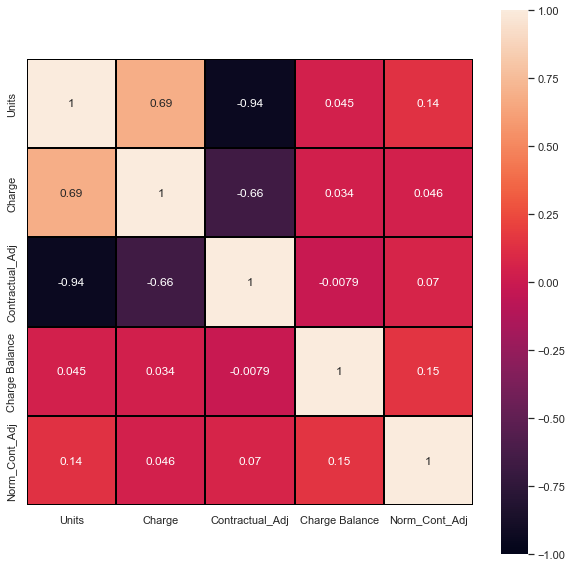

In [19]:
corr = df_patient.iloc[:,:].corr(method='pearson')
plt.figure(figsize=(10,10))
sns.heatmap(corr, vmax=1.0, vmin=-1.0, linewidth=0.01, square=True, annot=True, cmap='rocket', linecolor='black')
plt.show()